In [ ]:
!pip install tensorflow
import os
import kagglehub
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
# Step 1: Download dataset
path = kagglehub.dataset_download("fernando2rad/x-ray-lung-diseases-images-9-classes")
print("Dataset downloaded to:", path)


Dataset downloaded to: /kaggle/input/x-ray-lung-diseases-images-9-classes


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

def split_dataset(source_dir, output_dir, train_ratio=0.7, val_ratio=0.15):
    classes = os.listdir(source_dir)

    for class_name in classes:
        class_path = os.path.join(source_dir, class_name)
        images = os.listdir(class_path)
        train_val, test = train_test_split(images, test_size=1 - (train_ratio + val_ratio), random_state=42)
        train, val = train_test_split(train_val, test_size=val_ratio / (train_ratio + val_ratio), random_state=42)

        for split_name, split_data in zip(['train', 'val', 'test'], [train, val, test]):
            split_class_dir = os.path.join(output_dir, split_name, class_name)
            os.makedirs(split_class_dir, exist_ok=True)
            for img in split_data:
                src = os.path.join(class_path, img)
                dst = os.path.join(split_class_dir, img)
                shutil.copy(src, dst)

# Usage:
processed_source = '/kaggle/input/x-ray-lung-diseases-images-9-classes'
processed_output = '/kaggle/working/xray_split'
split_dataset(processed_source, processed_output)


from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

# Set up data generators
train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(processed_output, 'train'),
    target_size=(256, 256),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    directory=os.path.join(processed_output, 'val'),
    target_size=(256, 256),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    directory=os.path.join(processed_output, 'test'),
    target_size=(256, 256),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 4712 images belonging to 9 classes.
Found 1014 images belonging to 9 classes.
Found 1017 images belonging to 9 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Concatenate


In [ ]:
# Step 1: Adapt grayscale input for ResNet50 (expects 3 channels)
# Convert grayscale to 3-channel by duplicating the single channel
def grayscale_to_rgb(x):
    return tf.image.grayscale_to_rgb(x)

train_generator = train_generator
val_generator = val_generator
test_generator = test_generator


In [ ]:
# Step 2: Build modified ResNet50 model
IMG_SIZE = (256, 256)
NUM_CLASSES = train_generator.num_classes
INIT_LR = 1e-4
EPOCHS = 10


In [ ]:
# Input shape must match 3 channels for ResNet50
input_tensor = Input(shape=(256, 256, 1))
x = tf.keras.layers.Lambda(grayscale_to_rgb)(input_tensor)  # Convert grayscale to RGB


In [ ]:
# Load base ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=x)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:

# Freeze or fine-tune layers
for layer in base_model.layers:
    layer.trainable = True  # Fine-tuning
# Add custom head
head = base_model.output
head = AveragePooling2D(pool_size=(7, 7))(head)
head = Flatten()(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.5)(head)
output = Dense(NUM_CLASSES, activation='softmax')(head)

model = Model(inputs=input_tensor, outputs=output)


In [ ]:
# Step 3: Compile model
opt = Adam(learning_rate=INIT_LR)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


In [ ]:
# Step 4: Callbacks
checkpoint = ModelCheckpoint("best_resnet50_xray.h5", monitor='val_accuracy', save_best_only=True, mode='max')
earlystop = EarlyStopping(patience=5, restore_best_weights=True)


In [ ]:
# Step 5: Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint, earlystop]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.5279 - loss: 1.4321

148/148 ━━━━━━━━━━━━━━━━━━━━ 150s 581ms/step - accuracy: 0.5290 - loss: 1.4288 - val_accuracy: 0.1006 - val_loss: 8.3723
Epoch 2/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.8898 - loss: 0.3247

148/148 ━━━━━━━━━━━━━━━━━━━━ 91s 427ms/step - accuracy: 0.8899 - loss: 0.3245 - val_accuracy: 0.1568 - val_loss: 5.3970
Epoch 3/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 55s 373ms/step - accuracy: 0.9350 - loss: 0.1870 - val_accuracy: 0.1006 - val_loss: 7.4809
Epoch 4/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 55s 371ms/step - accuracy: 0.9528 - loss: 0.1603 - val_accuracy: 0.1055 - val_loss: 7.7092
Epoch 5/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.9709 - loss: 0.0978

148/148 ━━━━━━━━━━━━━━━━━━━━ 61s 412ms/step - accuracy: 0.9709 - loss: 0.0979 - val_accuracy: 0.2051 - val_loss: 4.5011
Epoch 6/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.9752 - loss: 0.0814

148/148 ━━━━━━━━━━━━━━━━━━━━ 78s 387ms/step - accuracy: 0.9752 - loss: 0.0814 - val_accuracy: 0.5473 - val_loss: 2.1436
Epoch 7/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.9733 - loss: 0.0839

148/148 ━━━━━━━━━━━━━━━━━━━━ 57s 382ms/step - accuracy: 0.9734 - loss: 0.0839 - val_accuracy: 0.8550 - val_loss: 0.4876
Epoch 8/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 55s 373ms/step - accuracy: 0.9744 - loss: 0.0829 - val_accuracy: 0.5099 - val_loss: 2.9325
Epoch 9/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 55s 372ms/step - accuracy: 0.9745 - loss: 0.0738 - val_accuracy: 0.8136 - val_loss: 0.6741
Epoch 10/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 57s 386ms/step - accuracy: 0.9867 - loss: 0.0490 - val_accuracy: 0.5651 - val_loss: 2.0578


In [ ]:
# Step 6: Evaluate
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc * 100:.2f}%")


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 234ms/step - accuracy: 0.8512 - loss: 0.5418
Test Accuracy: 87.51%


In [ ]:
# Step 7: Confusion matrix & report
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict and get labels
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))


32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 215ms/step

Classification Report:
                                                                                           precision    recall  f1-score   support

                                                                       00 Anatomia Normal       1.00      0.81      0.89       202
                                        01 Processos Inflamatórios Pulmonares (Pneumonia)       0.83      0.86      0.84       160
     02 Maior Densidade (Derrame Pleural, Consolidação Atelectasica, Hidrotorax, Empiema)       0.90      0.92      0.91       102
                      03 Menor Densidade (Pneumotorax, Pneumomediastino, Pneumoperitonio)       0.96      0.91      0.93        95
   04 Doenças Pulmonares Obstrutivas (Enfisema, Broncopneumonia, Bronquiectasia, Embolia)       0.82      0.82      0.82        97
      05 Doenças Infecciosas Degenerativas (Tuberculose, Sarcoidose, Proteinose, Fibrose)       0.62      0.97      0.75        90
         06 Lesõ

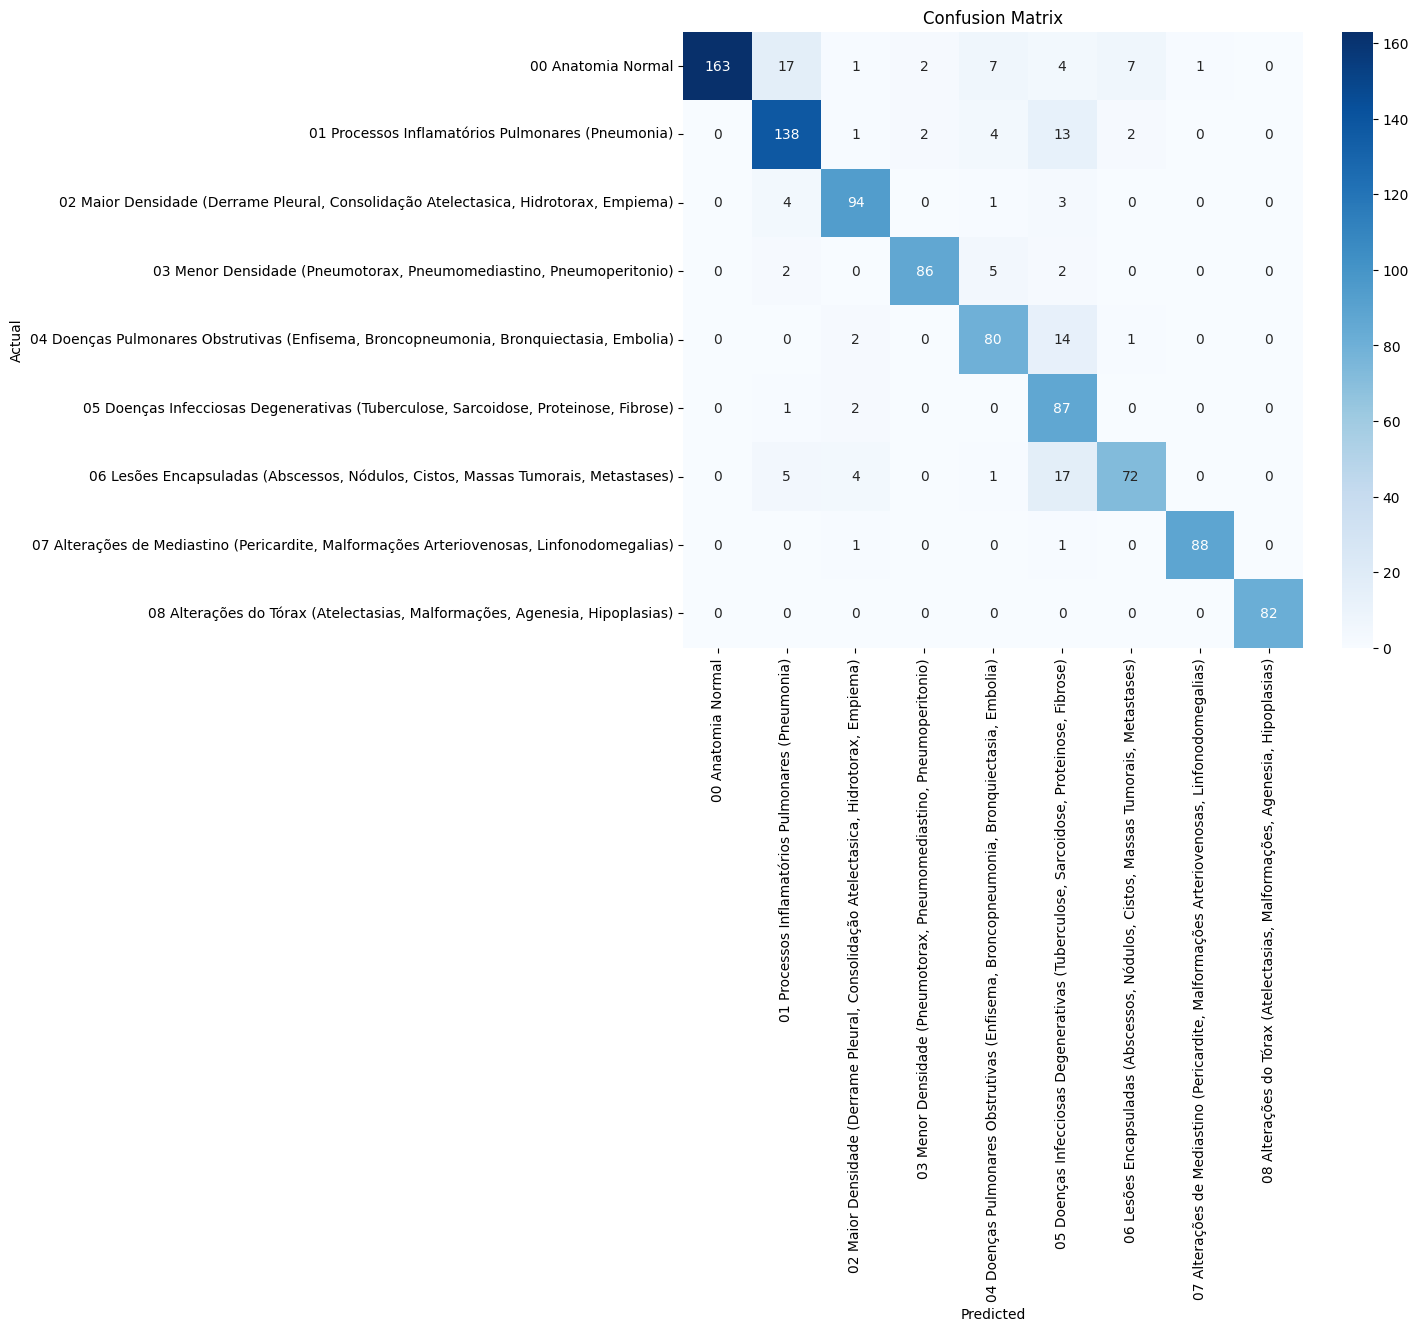

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 256, 256, 1))
  warnings.warn(msg)


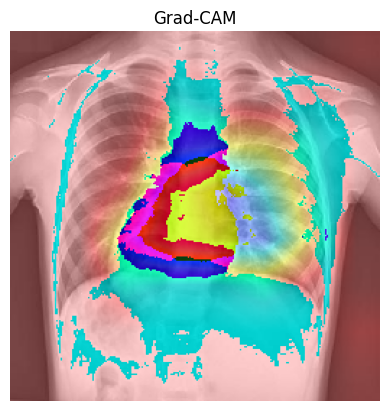

In [ ]:
import cv2
import tensorflow.keras.backend as K

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Choose a sample image
sample_img, _ = test_generator[0]  # First batch
img = sample_img[0:1]  # First image

# Generate heatmap
heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name='conv5_block3_out')

# Overlay heatmap
img_rgb = tf.image.grayscale_to_rgb(tf.convert_to_tensor(img)).numpy()[0]
heatmap_resized = cv2.resize(heatmap, (256, 256))
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
superimposed = heatmap_colored * 0.4 + (img_rgb * 255)

plt.imshow(np.uint8(superimposed))
plt.axis('off')
plt.title("Grad-CAM")
plt.show()


In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=52553baacfb537f91fca910f10476f8da9ba0a8c620acacfbe23773241d46222
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━

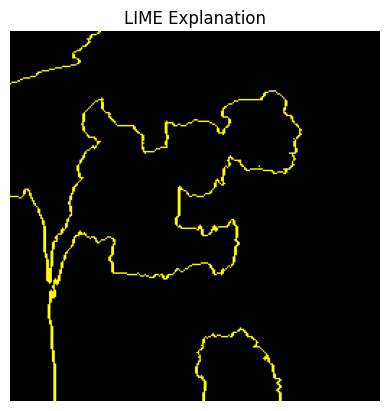

In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

explainer = lime_image.LimeImageExplainer()

# Prepare image (convert grayscale to RGB for LIME)
image = test_generator[0][0][0]
rgb_image = tf.image.grayscale_to_rgb(tf.expand_dims(image, axis=0))[0].numpy()

# Define prediction function for LIME
def predict_fn(images):
    images = np.array(images)
    images = tf.image.rgb_to_grayscale(images)
    return model.predict(images)

explanation = explainer.explain_instance(
    rgb_image.astype('double'),
    predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

# Show explanation
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    hide_rest=False,
    num_features=10,
    min_weight=0.0
)

plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title("LIME Explanation")
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

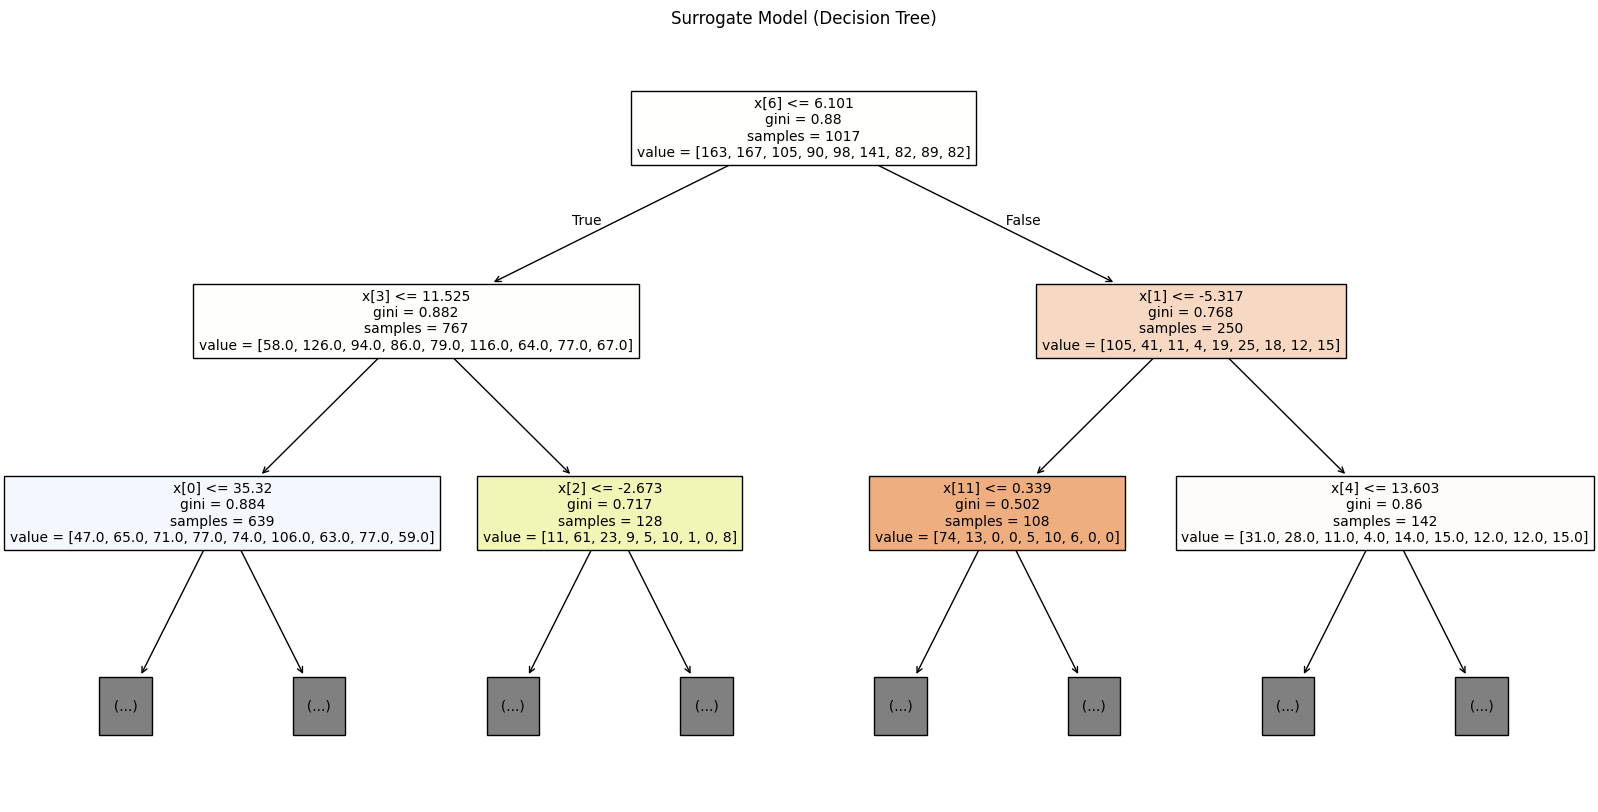

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

# Get all features and predictions
features = []
predictions = []
labels = []

for i in range(len(test_generator)):
    batch_x, batch_y = test_generator[i]
    features.append(batch_x.reshape(batch_x.shape[0], -1))
    preds = model.predict(batch_x)
    predictions.append(np.argmax(preds, axis=1))
    labels.append(np.argmax(batch_y, axis=1))

X = np.vstack(features)
y_true = np.hstack(labels)
y_pred = np.hstack(predictions)

# Reduce dimensions
pca = PCA(n_components=50)
X_reduced = pca.fit_transform(X)

# Train surrogate model
surrogate = DecisionTreeClassifier(max_depth=5)
surrogate.fit(X_reduced, y_pred)

print("Surrogate Accuracy:", accuracy_score(y_true, surrogate.predict(X_reduced)))

from sklearn import tree
plt.figure(figsize=(20, 10))
tree.plot_tree(surrogate, filled=True, max_depth=2, fontsize=10)
plt.title("Surrogate Model (Decision Tree)")
plt.show()
